**Izdiharti Noni Pertiwi** 

> dataset : delhi weather data

> Sumber kaggle : https://www.kaggle.com/mahirkukreja/delhi-weather-datata

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#dataframe
import pandas as pd
import numpy as np
#split data
from sklearn.model_selection import train_test_split
#preprocessing dan layer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout
#visualisasi plot
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Submission-ml-pengembangan/Delhi-weather-data.csv")
df.head(5)

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [5]:
#total data
df.shape

(100990, 20)

In [6]:
#data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   datetime_utc  100990 non-null  object 
 1    _conds       100918 non-null  object 
 2    _dewptm      100369 non-null  float64
 3    _fog         100990 non-null  int64  
 4    _hail        100990 non-null  int64  
 5    _heatindexm  29155 non-null   float64
 6    _hum         100233 non-null  float64
 7    _precipm     0 non-null       float64
 8    _pressurem   100758 non-null  float64
 9    _rain        100990 non-null  int64  
 10   _snow        100990 non-null  int64  
 11   _tempm       100317 non-null  float64
 12   _thunder     100990 non-null  int64  
 13   _tornado     100990 non-null  int64  
 14   _vism        96562 non-null   float64
 15   _wdird       86235 non-null   float64
 16   _wdire       86235 non-null   object 
 17   _wgustm      1072 non-null    float64
 18   _wi

In [7]:
#null check
df.isnull().sum()

datetime_utc         0
 _conds             72
 _dewptm           621
 _fog                0
 _hail               0
 _heatindexm     71835
 _hum              757
 _precipm       100990
 _pressurem        232
 _rain               0
 _snow               0
 _tempm            673
 _thunder            0
 _tornado            0
 _vism            4428
 _wdird          14755
 _wdire          14755
 _wgustm         99918
 _windchillm    100411
 _wspdm           2358
dtype: int64

In [8]:
df['datetime_utc']=pd.to_datetime(df['datetime_utc'])
df['datetime_utc'].head()
df[' _tempm'].fillna(df[' _tempm'].mean(), inplace=True) # we will fill the null row
df = df[['datetime_utc',' _tempm' ]]
df.head()

,datetime_utc,_tempm
0,1996-11-01 11:00:00,30.0
1,1996-11-01 12:00:00,28.0
2,1996-11-01 13:00:00,24.0
3,1996-11-01 14:00:00,24.0
4,1996-11-01 16:00:00,23.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   datetime_utc  100990 non-null  datetime64[ns]
 1    _tempm       100990 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 MB


In [10]:
delhi=df[['datetime_utc',' _tempm']].copy()
delhi['just_date'] = delhi['datetime_utc'].dt.date

DF=delhi.drop('datetime_utc',axis=1)
DF.set_index('just_date', inplace= True)
DF.head()

,_tempm
just_date,
1996-11-01,30.0
1996-11-01,28.0
1996-11-01,24.0
1996-11-01,24.0
1996-11-01,23.0


In [11]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100990 entries, 1996-11-01 to 2017-04-24
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0    _tempm  100990 non-null  float64
dtypes: float64(1)
memory usage: 1.5+ MB


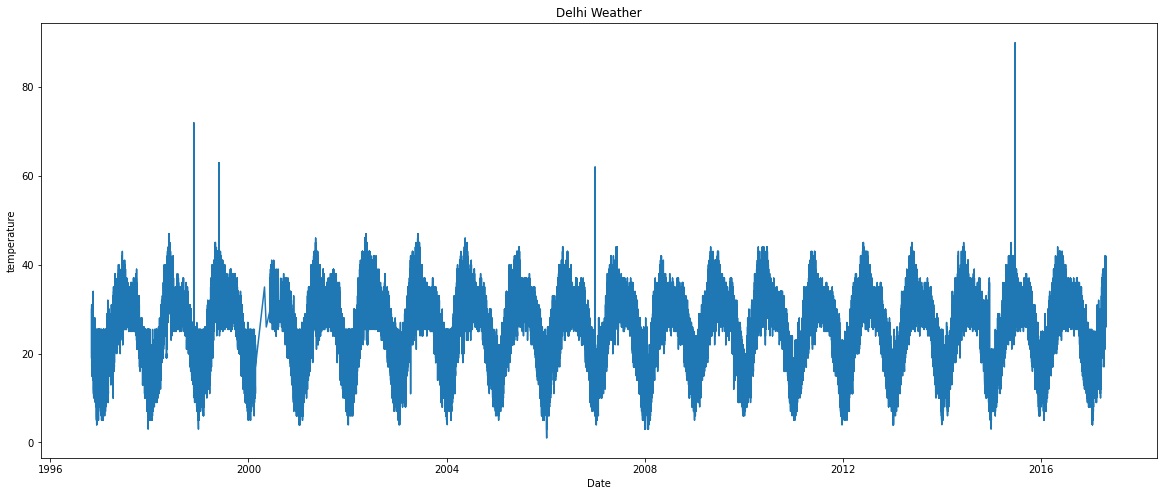

In [12]:
date = df['datetime_utc'].values
temp = df[' _tempm'].values

plt.figure(figsize=(20,8))
plt.plot(DF)
plt.title('Delhi Weather')
plt.xlabel('Date')
plt.ylabel('temperature')
plt.show()

In [13]:
#Split Dataset
x_train, x_test, y_train, y_test = train_test_split(temp, date, test_size = 0.2, random_state = 0 , shuffle=False)

In [14]:
#Total data train (80%) dan validation (20%)
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_test))

Total Data Train :  80792
Total Data Validation :  20198


In [15]:
#Merubah data u/ dapat diterima model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [16]:
#Pemodelan Sequential

data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [17]:
#Menghitung nilai 10% MAE u/ penerapan callback"""

x = (df[' _tempm'].max() - df[' _tempm'].min()) * 10/100
print(x)

8.9


In [18]:
#Penggunaan Callback <10% MAE

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<x and logs.get('val_mae')<x):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [19]:
#Penggunaan learning rate SGD untuk optimizer
tf.keras.backend.set_floatx('float64')
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(data_x_train ,epochs=500, validation_data=data_x_test, callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
808/808 [==============================] - 99s 118ms/step - loss: 7.9800 - mae: 8.4639 - val_loss: 6.2853 - val_mae: 6.7695

MAE dari model < 10% skala data


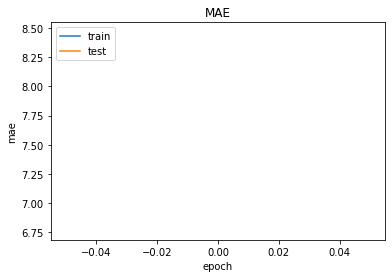

In [20]:
# plot of mae
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

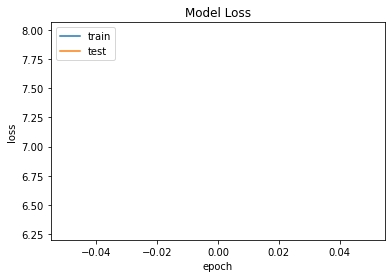

In [21]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()